# Tutorial

This notebook is the tutorial and user guide for the algorithm implemented in https://github.com/BoxiLi/repeater-cut-off-optimization.

In [12]:
import numpy as np
import matplotlib.pyplot as plt

from repeater_algorithm import plot_algorithm, RepeaterChainSimulation

## Entanglement swap
In the following example, we simulate a swap protocol of three nodes, where the middle one is a repeater.

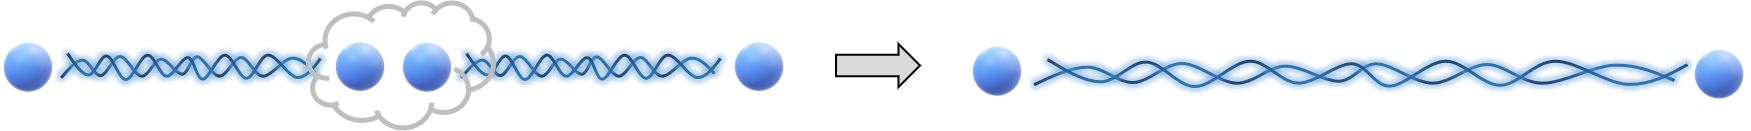

First, we define the following parameters for the simulation:
- `protocol`: Asymmetric protocol is represented by a tuple of 0 and 1, where 0 stands for swap and 1 stands for distillation. In this example we have only one entanglement swapping, hence it is a single-element tuple `(0,)`;
- `p_gen`: The success probability of direct entanglement generation between two adjacent nodes;
- `lambdas`: The initial Bell diagonal parameter of the state. In order to represent the state, we create a list with four contents [`φ+, φ+, ψ+, ψ-`]
- `t_trunc`: The truncation time of the simulation. It should be chosen large enough so that the almost all probability distribution (>99%) is included.
- `depolarizing_rate`: Probability of depolarizing noise effecting the entangled links.
- `dephasing_rate`: Probability of dephasing noise effecting the entangled links.

In [13]:
parameters = {
    "protocol": (0,),
    "p_gen": 0.01,
    "lambdas": [0.85, 0.05, 0.05, 0.05],
    "t_trunc": 3000,
    # "depolarizing_rate": 1 - np.exp(-50000/3000),
    # "dephasing_rate": 0.001,    
}

In [14]:
# Initialize simulator
simulator = RepeaterChainSimulation()
# compute the waiting time distribution and the time-dependent parameters
pmf, l_func = simulator.bell_diagonal_protocol(parameters)

### Time distribution
We can plot the distribution of obtaining the end-to-end entanglement:

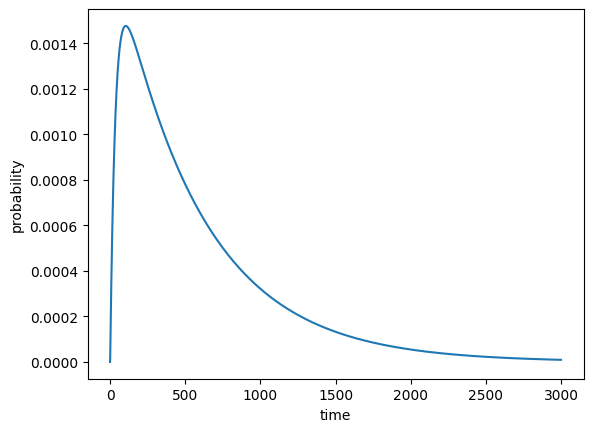

In [15]:
plt.plot(pmf)
plt.xlabel("time")
plt.ylabel("probability")
plt.show()

The plot above shows the waiting time distribution of this three-node swap protocol. In the first few time steps, the probability is very low because the two direct entangled pairs are note prepared. The distribution peaks around 200.

We can compute the probability mass that is covered by this distribution

We can also calculate the average waiting time and compare it with the analytical result.

In [16]:
# numerical
from utility_functions import get_mean_waiting_time
numerical_result = get_mean_waiting_time(pmf)
# analytical
p_gen = parameters["p_gen"]
analytical_result = (3-2*p_gen)/((2-p_gen)*p_gen / 4)

print("Numerical result:", numerical_result)
print("Analytical result:", analytical_result)

Numerical result: 599.1823386357937
Analytical result: 598.9949748743718


### Fidelity
Same as the waiting time, we cal also plot the quality of the entanglement as a function of time. Here, we use `werner_to_fid` and `fid_to_werner` to transfer between the Werner parameter and the fidelity. Notice that the first few steps might be inaccurate because their probability is so small that leads to numerical instability. 

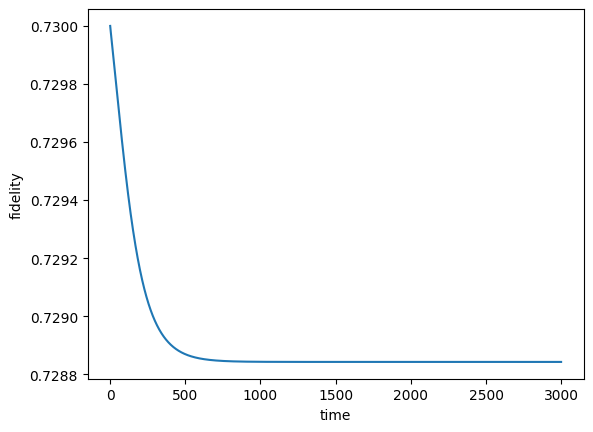

In [17]:
from utility_functions import bell_to_fid
l_func[:1] = np.nan
fidelity = bell_to_fid(l_func)
plt.plot(fidelity)
plt.xlabel("time")
plt.ylabel("fidelity")
plt.show()

We see from the above figure that, due to memory decay, the later the entanglement is produced, the lower is its fidelity. Since we neglect other noise in the quantum operation, we can in principle obtain a perfect entanglement at time step 1, although the probability is extremely low. We compute the average fidelity:

In [18]:
from utility_functions import get_mean_bell
get_mean_bell(pmf, l_func)

np.float64(0.7290477866970069)

## Entanglemen distillation/purification
Entanglement distillation is used to improve the fidelity of entangled qubits e.g. by merging two entangled pairs followed by postselection.

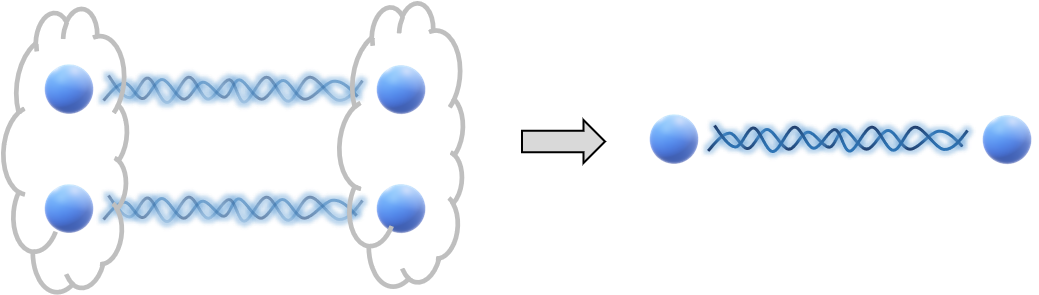

Here we use the [BBPSSW](https://arxiv.org/abs/quant-ph/9511027) distillation protocol. Distillation is represented by 1 in our protocol. We add a distillation on top of the swap protocol we've plotted above. The whole protocol now has 3 nodes. Two pairs of qubits will be first entangled by swapping in parallel. After they are both prepared, the distillation is executed.

In [19]:
parameters["protocol"] = (1,)

In [20]:
simulator = RepeaterChainSimulation()
pmf, l_func = simulator.bell_diagonal_protocol(parameters)
print("Average waiting time", get_mean_waiting_time(pmf))
print("Average fidelity", get_mean_bell(pmf, l_func))

Average waiting time 182.76206408362793
Average fidelity 0.8836199861154906


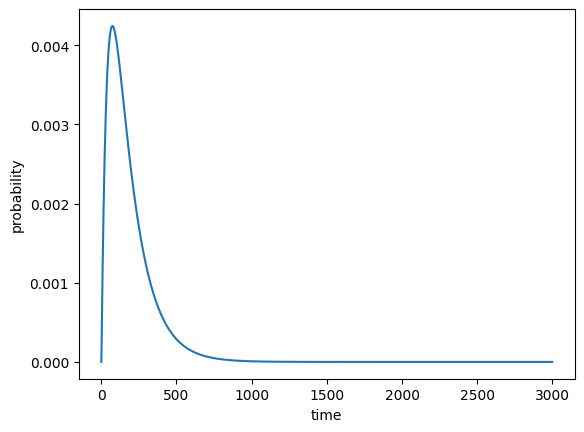

In [21]:
# pmf = [sublist[0] for sublist in pmf]
plt.plot(pmf)
plt.xlabel("time")
plt.ylabel("probability")
plt.show()

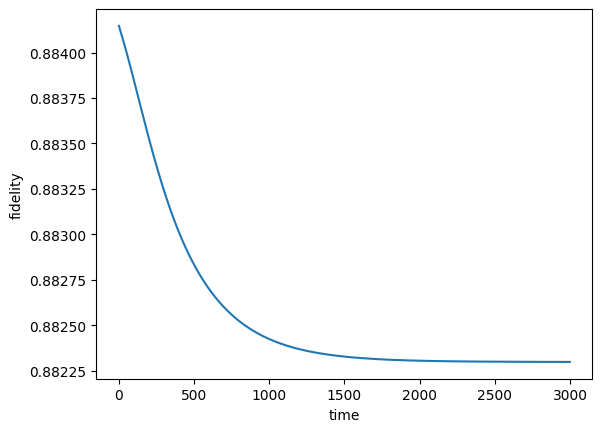

In [22]:
from utility_functions import bell_to_fid
l_func[:1] = np.nan
fidelity = bell_to_fid(l_func)
plt.plot(fidelity)
plt.xlabel("time")
plt.ylabel("fidelity")
plt.show()

In [23]:
lfunc_phiplus = [sublist[0] for sublist in l_func]
sum(lfunc_phiplus[1:])

np.float64(2646.760384954737)

## Cut-off

Cut-off set a limit on the entanglement distribution process. For instance, usually, one entangled pair is usually generated and stored in the quantum memory, waiting for the other pair to be prepared. The fidelity decays during the storage because of noise. Sometimes, it is beneficial to set a limit on the storage time. If the storage time exceeds the threshold. The process is terminated and restarts from entanglement generation between adjacent nodes.

Here we use the 3-node swap protocol again, but now with a cut-off. Because cut-off is only effective for small coherence time. We modify the parameters for this comparison.

We can use `list` in parameters and `create_iter_ikwargs` to iterate over different cutoff values.

In [24]:
parameters = {
    "protocol": (0,),
    "p_gen": 0.01,
    "lambdas": [[0.985, 0.005, 0.005, 0.005]],  # fidelity 0.95
    "t_trunc": 3000,
    # "depolarizing_rate": 0.001,
    # "dephasing_rate": 0.0005,
    "cut_type": "memory_time",
    "cutoff": [1000000, 50],
}

from logging_utilities import create_iter_kwargs
parameters_list = create_iter_kwargs(parameters)
print("First parameter set")
print(parameters_list[0])
print("Second parameter set")
print(parameters_list[1])

pmf1, l_func1 = simulator.bell_diagonal_protocol(parameters_list[0])
pmf2, l_func2 = simulator.bell_diagonal_protocol(parameters_list[1])

First parameter set
{'protocol': (0,), 'p_gen': 0.01, 'lambdas': [0.985, 0.005, 0.005, 0.005], 't_trunc': 3000, 'cut_type': 'memory_time', 'cutoff': 1000000}
Second parameter set
{'protocol': (0,), 'p_gen': 0.01, 'lambdas': [0.985, 0.005, 0.005, 0.005], 't_trunc': 3000, 'cut_type': 'memory_time', 'cutoff': 50}


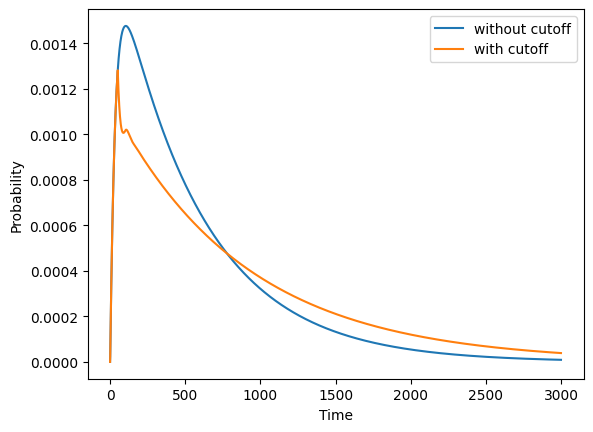

Average waiting time without cutoff 599.1823386357937
Average waiting time with cutoff 900.1341387462649


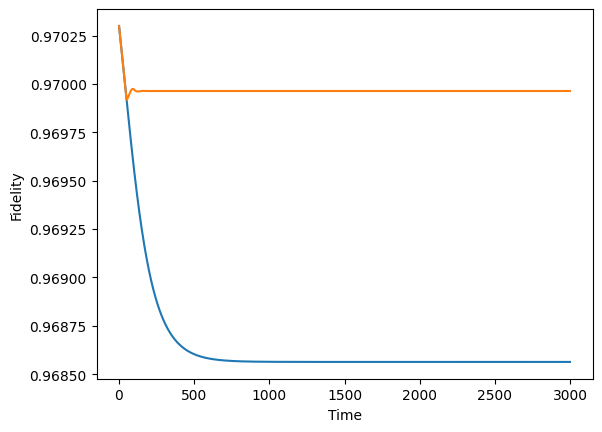

Average fidelity without cutoff 0.968871085027531
Average fidelity with cutoff 0.9699670481226501


In [25]:
tlist = np.arange(parameters["t_trunc"])
plt.plot(tlist, pmf1, tlist, pmf2)
plt.legend(("without cutoff", "with cutoff"))
plt.xlabel("Time")
plt.ylabel("Probability")
plt.show()
print("Average waiting time without cutoff", get_mean_waiting_time(pmf1))
print("Average waiting time with cutoff", get_mean_waiting_time(pmf2))

l_func1[:1] = np.nan
l_func2[:1] = np.nan
plt.plot(tlist, bell_to_fid(l_func1), tlist, bell_to_fid(l_func2))
plt.xlabel("Time")
plt.ylabel("Fidelity")
plt.show()
print("Average fidelity without cutoff", get_mean_bell(pmf1, l_func1))
print("Average fidelity with cutoff", get_mean_bell(pmf2, l_func2))

## High-level symmetric protocols
The code offers a simple way to define nested symmetric protocols. In these protocols, the two entangled pairs used in swap or distillation at higher levels are produced by the same protocol used to generate current-level entanglement. For instance, a protocol with 9 nodes and 8 segments that executes 3 rounds of entanglement swapping can be defined by

average waiting time: 55298.72512702892


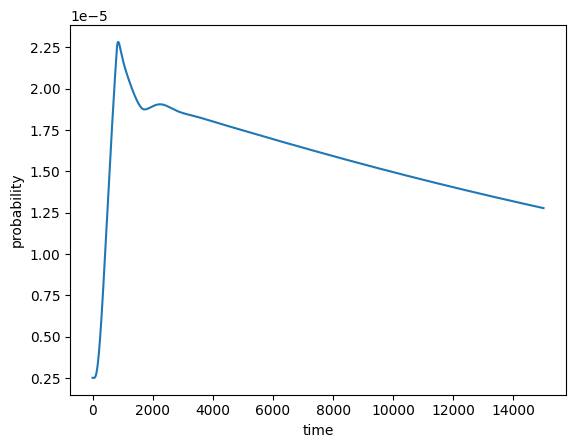

In [26]:
parameters = {
    "protocol": (0, 0, 0,),
    "p_gen": 0.01,
    "lambdas": [1., 0., 0., 0.],
    # "t_coh": 8000,
    "mt_cut": 800,
    "t_trunc": 15000,
}

simulator = RepeaterChainSimulation()
pmf, l_func = simulator.bell_diagonal_protocol(parameters)
print("average waiting time:", get_mean_waiting_time(pmf))

plt.plot(pmf)
plt.xlabel("time")
plt.ylabel("probability")
plt.show()

Another example includes dsitillation

average waiting time: 6702.614073820122


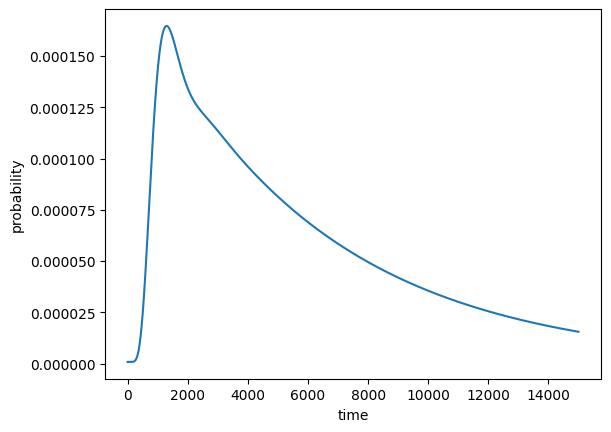

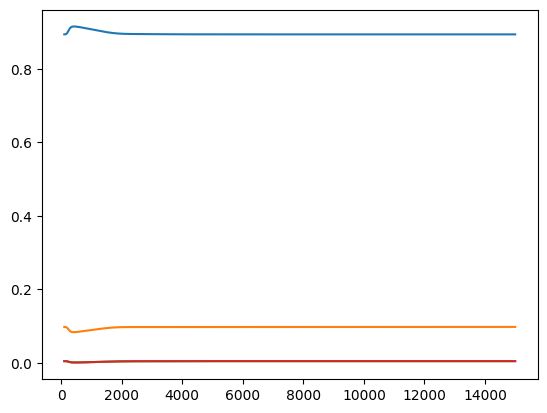

In [27]:
parameters = {
    "protocol": (0, 1, 1, 0,),
    "p_gen": 0.01,
    "lambdas": [0.985, 0.005, 0.005, 0.005],
    # "dephasing_rate": 0.001,
    # "depolarizing_rate": 0.002,
    "t_trunc": 15000,
    "mt_cut": 15000,
}

simulator = RepeaterChainSimulation()
pmf, l_func = simulator.bell_diagonal_protocol(parameters)
print("average waiting time:", get_mean_waiting_time(pmf))
plt.plot(pmf)
plt.xlabel("time")
plt.ylabel("probability")
plt.show()
l_func[:100] = np.nan
plt.plot(l_func)

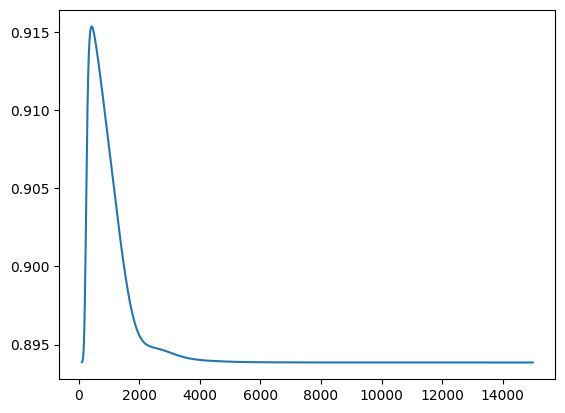

In [28]:
fidelity = [sublist[0] for sublist in l_func]
plt.plot(fidelity)

## Optimization of cut-offs

The optimization using differential evolution algorithm is implemented in the class `CutoffOptimizer`.

In [21]:
from optimize_cutoff import CutoffOptimizer
parameters = {
    "protocol": (0,),
    "p_gen": 0.01,
    "lambdas": [0.98, 0.01, 0.005, 0.005],  # fidelity 0.95
    "t_trunc": 3000,
    "cut_type": "memory_time",
}

# We use the logging system to show the information
import logging
from logging_utilities import log_init
log_init("cutoff_optimze", level=logging.INFO)

optimizer = CutoffOptimizer(adaptive=True)
optimizer.run(parameters)

INFO:root:ID: cutoff_optimze-20250205-171502
INFO:root:Date: 2025-02-05 17:15:02

INFO:root:-------------------------------------------
INFO:root:Optimization of the cut-off time

INFO:root:Parameters:
protocol (0,)
p_gen 0.01
lambdas [0.98, 0.01, 0.005, 0.005]
t_trunc 3000
cut_type memory_time

INFO:root:Pretraining begins...
INFO:root:Pretraining finishes, reference pmf obtained.


AttributeError: 'RepeaterChainSimulation' object has no attribute 'nested_protocol'

The optimal cutoff is `cutoff=64`.

We now perform an optimization on a 3-level swapping protocol.

In [16]:
from optimize_cutoff import CutoffOptimizer
parameters = {
    "protocol": (0, 0, 0),
    "p_gen": 0.01,
    "p_swap": 0.5,
    "w0": 0.98,  # fidelity 0.95
    "t_coh": 4000,
    "t_trunc": 30000,
    "cut_type": "memory_time",
}
optimizer = CutoffOptimizer(adaptive=True)
optimizer.run(parameters)

INFO:root:-------------------------------------------
INFO:root:Optimization of the cut-off time

INFO:root:Parameters:
protocol (0, 0, 0)
p_gen 0.01
p_swap 0.5
w0 0.98
t_coh 4000
t_trunc 30000
cut_type memory_time

INFO:root:Pretraining begins...
INFO:root:Pretraining finishes, reference pmf obtained.


differential_evolution step 1: f(x)= -3.15235e-05
convergence: 0.008748307198404559
differential_evolution step 2: f(x)= -3.2011e-05
convergence: 0.009579955012684315
differential_evolution step 3: f(x)= -3.2011e-05
convergence: 0.01773439461628236
differential_evolution step 4: f(x)= -3.21654e-05
convergence: 0.02210663073998935
differential_evolution step 5: f(x)= -3.23437e-05
convergence: 0.034138488490878756
differential_evolution step 6: f(x)= -3.24101e-05
convergence: 0.04952814345619631
differential_evolution step 7: f(x)= -3.2634e-05
convergence: 0.0788969373399929
differential_evolution step 8: f(x)= -3.2634e-05
convergence: 0.08724550192123384
differential_evolution step 9: f(x)= -3.2634e-05
convergence: 0.08742065598604162
differential_evolution step 10: f(x)= -3.2634e-05
convergence: 0.11953994045583267
differential_evolution step 11: f(x)= -3.26785e-05
convergence: 0.1543225720698017
differential_evolution step 12: f(x)= -3.26785e-05
convergence: 0.1536998575742704
differe

INFO:root:Local optimal check fails. The best tau found is not optimal. Neighboring tau = {'memory_time': array([177, 325, 527])} is better with an increase in the secrete key rate of 0.02%.

INFO:root:The current tau found: {'memory_time': array([176, 324, 526])}
The current cut-off is located at: [0.82895779 0.66144318 0.41134007]
The current key rate is 3.2695528789585244e-05
INFO:root:The following change has been made to the parameters:
INFO:root:'popsize' is increased to 15.
INFO:root:Search region for tau[0] is restricted to (99,30001).
INFO:root:Search region for tau[1] is restricted to (203,558).
INFO:root:Search region for tau[2] is restricted to (306,832).
INFO:root:Optimization fails to find the best cut-off. Restarting.



differential_evolution step 1: f(x)= -3.26413e-05
convergence: 0.026147043571774612
differential_evolution step 2: f(x)= -3.26413e-05
convergence: 0.032666967003743615
differential_evolution step 3: f(x)= -3.26413e-05
convergence: 0.03385761457082726
differential_evolution step 4: f(x)= -3.26413e-05
convergence: 0.03848906447059242
differential_evolution step 5: f(x)= -3.26874e-05
convergence: 0.04157423638173781
differential_evolution step 6: f(x)= -3.26973e-05
convergence: 0.05135657079973709
differential_evolution step 7: f(x)= -3.27043e-05
convergence: 0.054606967264130835
differential_evolution step 8: f(x)= -3.27165e-05
convergence: 0.05644150995441407
differential_evolution step 9: f(x)= -3.27165e-05
convergence: 0.09023382523171097
differential_evolution step 10: f(x)= -3.27346e-05
convergence: 0.14145224955272717
differential_evolution step 11: f(x)= -3.27346e-05
convergence: 0.23440472892124165
differential_evolution step 12: f(x)= -3.27361e-05
convergence: 0.2685162064553755

INFO:root:Local optimal check fails. The best tau found is not optimal. Neighboring tau = {'memory_time': array([176, 333, 551])} is better with an increase in the secrete key rate of 0.00%.

INFO:root:The current tau found: {'memory_time': array([176, 334, 550])}
The current cut-off is located at: [0.53632047 0.52571856 0.54240139]
The current key rate is 3.27360668006538e-05
INFO:root:The following change has been made to the parameters:
INFO:root:'popsize' is increased to 22.
INFO:root:Search region for tau[0] is restricted to (140,235).
INFO:root:Search region for tau[1] is restricted to (276,409).
INFO:root:Search region for tau[2] is restricted to (452,664).
INFO:root:Optimization fails to find the best cut-off. Restarting.



differential_evolution step 1: f(x)= -3.27122e-05
convergence: 0.027757211920816885
differential_evolution step 2: f(x)= -3.27262e-05
convergence: 0.03929322474872825
differential_evolution step 3: f(x)= -3.27262e-05
convergence: 0.04884189942914737
differential_evolution step 4: f(x)= -3.27262e-05
convergence: 0.05757710533790317
differential_evolution step 5: f(x)= -3.27349e-05
convergence: 0.0771702603316927
differential_evolution step 6: f(x)= -3.27349e-05
convergence: 0.08445823364392673
differential_evolution step 7: f(x)= -3.27379e-05
convergence: 0.10093720492385243
differential_evolution step 8: f(x)= -3.27379e-05
convergence: 0.13672129844715192
differential_evolution step 9: f(x)= -3.27379e-05
convergence: 0.17127789928858436
differential_evolution step 10: f(x)= -3.27419e-05
convergence: 0.28705125173545926
differential_evolution step 11: f(x)= -3.27419e-05
convergence: 0.37879955812295313
differential_evolution step 12: f(x)= -3.27419e-05
convergence: 0.4143161976247225
di

INFO:root:The best tau found: {'memory_time': array([176, 327, 559])}
The best cut-off is located at: [0.49092713 0.44069782 0.53806474]
The best key rate is 3.27432266099328e-05

INFO:root:-------------------------------------------


{'memory_time': array([176, 327, 559])}

The best cutoff time on each level is different.

One can also force all the cutoff time to be the same.

In [17]:
optimizer = CutoffOptimizer(adaptive=True, opt_kind="uniform_de")
optimizer.run(parameters)

INFO:root:-------------------------------------------
INFO:root:Optimization of the cut-off time

INFO:root:Parameters:
protocol (0, 0, 0)
p_gen 0.01
p_swap 0.5
w0 0.98
t_coh 4000
t_trunc 30000
cut_type memory_time

INFO:root:Pretraining begins...
INFO:root:Pretraining finishes, reference pmf obtained.


differential_evolution step 1: f(x)= -2.90465e-05
convergence: 0.0043184284209310765
differential_evolution step 2: f(x)= -2.91768e-05
convergence: 0.006302171827087236
differential_evolution step 3: f(x)= -2.91768e-05
convergence: 0.008377904422255665
differential_evolution step 4: f(x)= -2.91768e-05
convergence: 0.011105814431417387
differential_evolution step 5: f(x)= -2.91768e-05
convergence: 0.011889122421378469
differential_evolution step 6: f(x)= -2.91768e-05
convergence: 0.024642099962111672
differential_evolution step 7: f(x)= -2.91768e-05
convergence: 0.029695255392237
differential_evolution step 8: f(x)= -2.93788e-05
convergence: 0.04230132891137778
differential_evolution step 9: f(x)= -2.95055e-05
convergence: 0.1634046106844596
differential_evolution step 10: f(x)= -2.95055e-05
convergence: 0.27606736357469686
differential_evolution step 11: f(x)= -2.95055e-05
convergence: 0.7953735043762681
differential_evolution step 12: f(x)= -2.95088e-05
convergence: 10.829489932929945

INFO:root:Local optimal check fails. The best tau found is not optimal. Neighboring tau = {'memory_time': array([370, 370, 370])} is better with an increase in the secrete key rate of 0.00%.

INFO:root:The current tau found: {'memory_time': array([369, 369, 369])}
The current cut-off is located at: [0.03732547]
The current key rate is 2.950878975959278e-05
INFO:root:The following change has been made to the parameters:
INFO:root:'popsize' is increased to 15.
INFO:root:Search region for tau[0] is restricted to (0,958).
INFO:root:Optimization fails to find the best cut-off. Restarting.



differential_evolution step 1: f(x)= -2.95092e-05
convergence: 0.006919278910042794
differential_evolution step 2: f(x)= -2.95092e-05
convergence: 0.009976855977491185
differential_evolution step 3: f(x)= -2.95092e-05
convergence: 0.018765787358942358
differential_evolution step 4: f(x)= -2.95092e-05
convergence: 0.06658496995173431
differential_evolution step 5: f(x)= -2.95092e-05
convergence: 0.07035186391618654
differential_evolution step 6: f(x)= -2.95092e-05
convergence: 0.14496509137374075
differential_evolution step 7: f(x)= -2.95092e-05
convergence: 0.26455069676446347
differential_evolution step 8: f(x)= -2.95092e-05
convergence: 0.2584060783704771
differential_evolution step 9: f(x)= -2.95092e-05
convergence: 0.36453330847427207
differential_evolution step 10: f(x)= -2.95092e-05
convergence: 0.534324828213304
differential_evolution step 11: f(x)= -2.95092e-05
convergence: 0.7674222030380602
differential_evolution step 12: f(x)= -2.95092e-05
convergence: 1.9532332129929417


INFO:root:The best tau found: {'memory_time': array([371, 371, 371])}
The best cut-off is located at: [0.15830663]
The best key rate is 2.9509223399818665e-05

INFO:root:-------------------------------------------


{'memory_time': array([371, 371, 371])}

## Logging system and data saving

## Asymmetric protocols and advanced use

## Density matrix representation